In [1]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt



import Image_functions as mf
import jsonparser
from hloc.utils.viz import plot_images, plot_keypoints
from hloc import visualization

In [2]:
## On GPU-3
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [3]:
# path_to_image= Path("/home/Hierarchical-Localization/datasets/Trajectory3/Image_choosen3/image8.png")
path_to_image= Path("/home/Hierarchical-Localization/datasets/UsefulImagesT4_scale_0.35/iPhoSilWithWv4_1598593699_982-02205.png")
path_to_mask = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT4_scale_0.35_mask/iPhoSilWithWv4_1598593699_982-02205.png")
path_to_json = Path("/home/Hierarchical-Localization/datasets/UsefulPosesT4HH")
path_to_model = Path("/home/Hierarchical-Localization/outputs/sfm_T3_pba")
image_name_ori = "iPhoSilWithWv4_1598593699_982-02205.png"
model = path_to_model/"sfm_superpoint+superglue"/"geo_registered_model"

In [4]:
names_trans_rot = jsonparser.parser(str(path_to_json))
# print((names_trans_rot.keys()))
tvec_ori = names_trans_rot[image_name_ori]["tvec"]

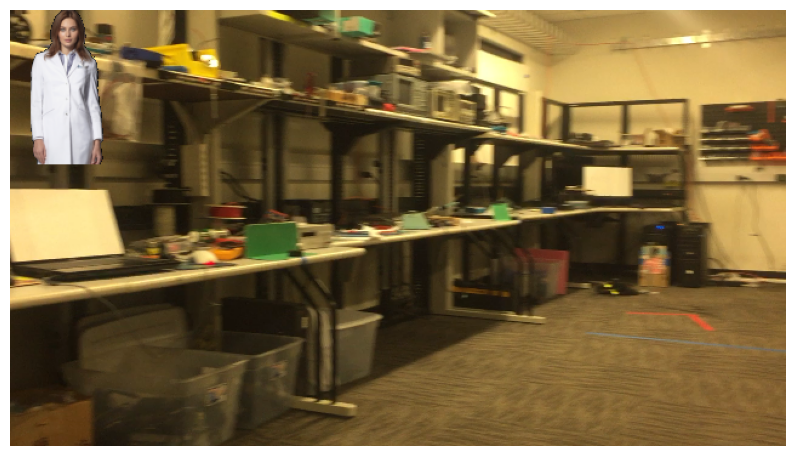

In [5]:
image_query = cv2.imread(str(path_to_image))
image_query = cv2.cvtColor(image_query, cv2.COLOR_BGR2RGB)
plot_images([image_query])

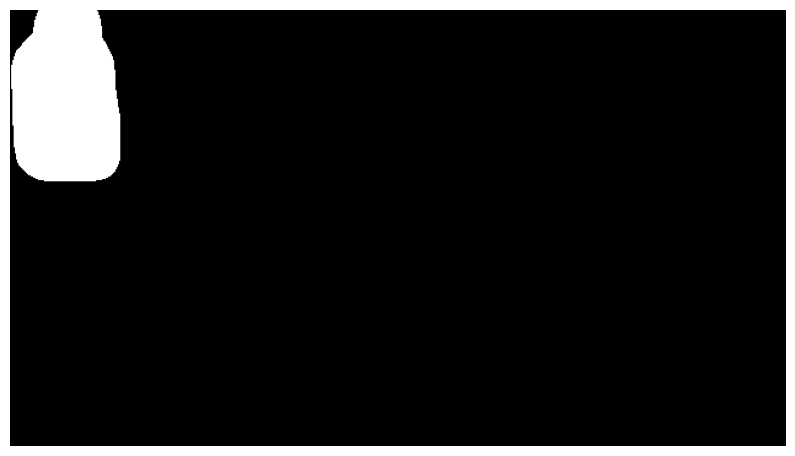

In [6]:
mask = cv2.imread(str(path_to_mask), cv2.IMREAD_GRAYSCALE)
plot_images([mask])

In [7]:
global_image_names, global_matrix = mf.global_descriptors_parser(path_to_model)
# If want to check the shapes
# len(global_image_names)
# np.shape(global_matrix)

In [8]:
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")
config_global = {'checkpoint_path':checkpoint_path, 
                 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 
                 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         

In [9]:
names_nearest, nearest_neighbours =mf.global_matches(path_to_model, config_global, image_query, 10)

W0302 13:48:25.084990 140247722952512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0302 13:48:25.106791 140247722952512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0302 13:48:25.107935 140247722952512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0302 13:48:25.109051 140247722952512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0302 13:48:25.112507 140247722952512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [10]:
# print(names_nearest)
nearest_neighbours

array([1544, 1546, 1543, 1545, 1542, 1547, 1548, 1549, 1550,  537])

In [11]:
feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


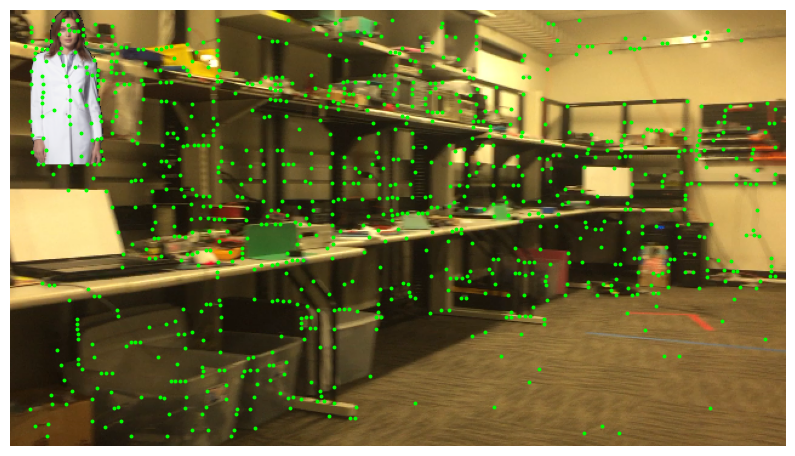

In [12]:
matches_dict,query_stuff = mf.local_descriptor_and_matches(image_query, path_to_model, feature_conf_superpoint, matcher_conf,names_nearest)
num = np.shape(query_stuff["keypoints"])

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


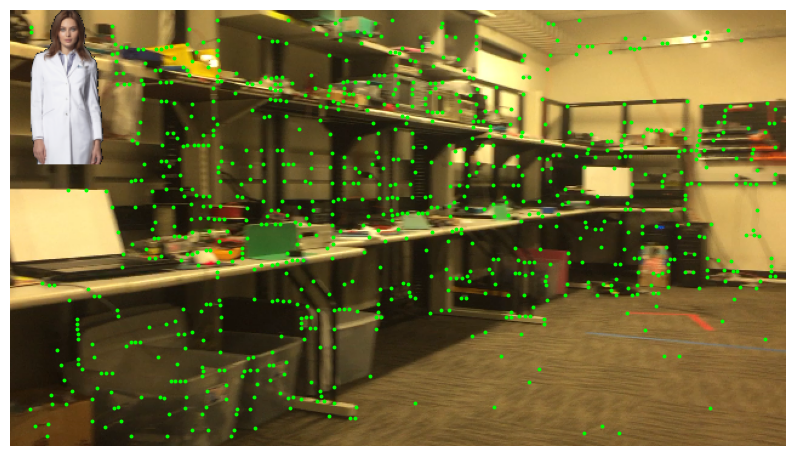

In [13]:
matched_dict_masked, query_stuff_masked = mf.local_descriptor_and_matches_mask(image_query, path_to_model, feature_conf_superpoint, matcher_conf,names_nearest, mask)
num_masked = np.shape(query_stuff_masked["keypoints"])

In [14]:
tvec_sfm = mf.localize(matches_dict, model, query_stuff, names_nearest )
err = mf.error(tvec_ori, tvec_sfm)
print("Error without masking is ", err)
print("The number of keypoints without masking are ", num)

Error without masking is  0.02988619190068648
The number of keypoints without masking are  (1016, 2)


In [15]:
tvec_sfm_masked = mf.localize(matched_dict_masked, model, query_stuff_masked,names_nearest)
err_masked = mf.error(tvec_ori, tvec_sfm_masked)
print("Error with masking is ", err_masked)
print("The number of keypoints with masking are ", num_masked)

Error with masking is  0.029843968672232796
The number of keypoints with masking are  (929, 2)
